<a href="https://colab.research.google.com/github/IshwaryaSriram/EfficentNet-ImageClassification/blob/main/DiabeticRetinopathyGrading/B0Models_transformedimages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the Dataset from Kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ishwaryasriram","key":"0c236b1d97bafa0285eca11f866a5a5a"}'}

In [ ]:
#setting up required directory to access kaggle dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=250f93660f2e7589edc3fdcee656227e6807f9a2aec9988aa7216613029ced8a
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
#downloading the datasaet (zipped file)
!kaggle datasets download -d sovitrath/diabetic-retinopathy-2015-data-colored-resized

100% 1.93G/1.94G [00:25<00:00, 77.6MB/s]
100% 1.94G/1.94G [00:25<00:00, 83.0MB/s]


In [ ]:
#extracting data from zip file
import zipfile
zip_ref = zipfile.ZipFile('diabetic-retinopathy-2015-data-colored-resized.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
cd files

/content/files


In [ ]:
#importing necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
%load_ext tensorboard
import datetime, os
from tensorflow.keras import layers
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

Exploratory Data Analysis

In [ ]:
#displaying the first few rows from the dataset 
dataset_csv = pd.read_csv('trainLabels.csv')
print(dataset_csv.dtypes)
print(dataset_csv.describe())

image    object
level     int64
dtype: object
              level
count  35126.000000
mean       0.526049
std        0.970390
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        4.000000


In [ ]:
# cd '../content/files'
print(
    len(os.listdir('colored_images/colored_images/Mild')) +
    len(os.listdir('colored_images/colored_images/Moderate')) +
    len(os.listdir('colored_images/colored_images/No_DR')) +
    len(os.listdir('colored_images/colored_images/Proliferate_DR')) +
    len(os.listdir('colored_images/colored_images/Severe'))
)

35126


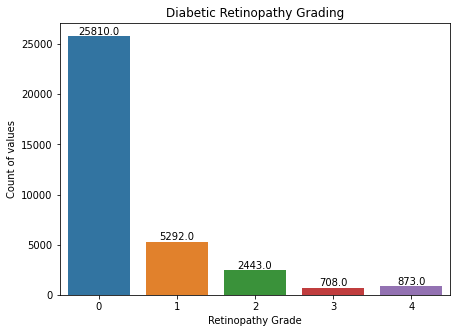

In [ ]:
#bar graph representing the dataset distribution
plt.figure(figsize=(7,5))
plt.title("Diabetic Retinopathy Grading")
data_plot = sns.barplot(x=dataset_csv.level.unique(), y=dataset_csv['level'].value_counts())
plt.ylabel("Count of values")
plt.xlabel("Retinopathy Grade")

for p in data_plot.patches:
    data_plot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 4.5), 
                   textcoords = 'offset points')


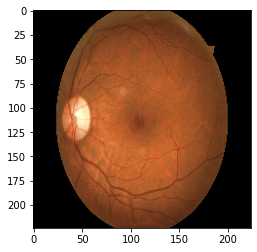

In [ ]:
#Plotting a sample image 

# import cv2 as cv
# from matplotlib import pyplot as plt

# from resizeimage import resizeimage

img = cv2.imread('colored_images/colored_images/Mild/10030_left.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


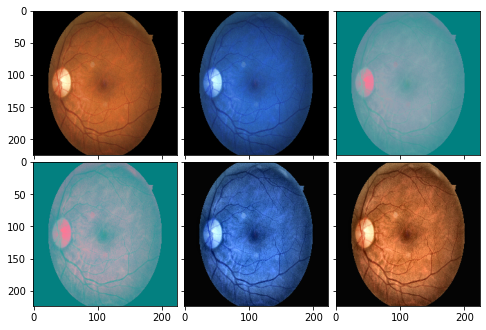

<Figure size 432x288 with 0 Axes>

In [ ]:
#sample image transformation
img = cv2.imread('colored_images/colored_images/Mild/10030_left.png')
img_2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

a = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
b = cv2.split(a)
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
b[0] = clahe.apply(b[0])
c = cv2.merge(b)
d = cv2.cvtColor(c, cv2.COLOR_LAB2BGR)
e =cv2.cvtColor(d, cv2.COLOR_BGR2RGB)
# plt.imshow(e)
l = [img_2,img,a,c,d,e]

from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, l):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()
# plt.savefig("imgtransformation.jpg")

In [ ]:
images = []
i = 0
for data in os.listdir('colored_images/colored_images/No_DR'):
        img_d = cv2.imread('colored_images/colored_images/No_DR/{}'.format(data))
        img_d = cv2.cvtColor(img_d, cv2.COLOR_BGR2LAB)

        lab_planes = cv2.split(img_d)
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        rgb =cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        if img_d is not None:            
            images.append([rgb,0])
        
        i+=1
        if i>=10000:
          break

i = 0
for data in os.listdir('colored_images/colored_images/Mild'):
        img_d = cv2.imread('colored_images/colored_images/Mild/{}'.format(data))
        img_d = cv2.cvtColor(img_d, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(img_d)
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        
        bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        rgb =cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        if img_d is not None:
            images.append([rgb,1])
        
        i+=1
        # if i>=max_length*6:
        #   break

i = 0
for data in os.listdir('colored_images/colored_images/Moderate'):
        img_d = cv2.imread('colored_images/colored_images/Moderate/{}'.format(data))
        img_d = cv2.cvtColor(img_d, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(img_d)
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        rgb =cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        if img_d is not None:
            images.append([rgb,1])
        
        i+=1
        # if i>=max_length*6:
        #   break

i = 0
for data in os.listdir('colored_images/colored_images/Proliferate_DR'):
        img_d = cv2.imread('colored_images/colored_images/Proliferate_DR/{}'.format(data))
        img_d = cv2.cvtColor(img_d, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(img_d)
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        rgb =cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        if img_d is not None:            
            images.append([rgb,1])
        
        i+=1
        # if i>=max_length*6:
        #   break

i = 0
for data in os.listdir('colored_images/colored_images/Severe'):
        img_d = cv2.imread('colored_images/colored_images/Severe/{}'.format(data))
        img_d = cv2.cvtColor(img_d, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(img_d)
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
        lab_planes[0] = clahe.apply(lab_planes[0])
        lab = cv2.merge(lab_planes)
        bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        rgb =cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        if img_d is not None:
            images.append([rgb,1])
        
        i+=1
        # if i>=max_length*6:
        #   break
        

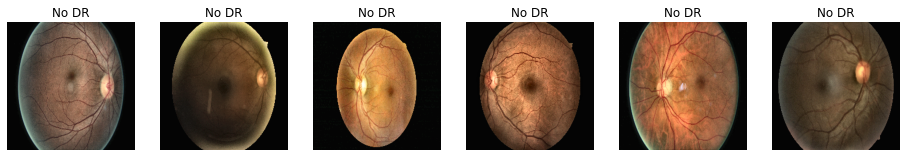

In [ ]:

w = 5
h = 5
fig = plt.figure(figsize=(16, 8))
columns = 6
rows = 1
j = 0
for i in range(1, columns*rows +1):
    j = random.randint(0,19316)
    image = images[l[j]][0]
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    plt.title('No DR' if images[j][1]==0 else 'DR Level: '+images[j][1] )
    plt.axis('off')
    j += 1
plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split

random.shuffle(images)
X_img = []
Y_lab = []
for data in images:
    X_img.append(data[0])
    Y_lab.append(data[1])

X_arr_img = np.array(X_img)

X_train, X_test, Y_train, Y_test = train_test_split(X_arr_img, Y_lab, test_size=0.3)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


In [ ]:
images = []
X_img = []
Y_lab = []

In [ ]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(13521, 224, 224, 3) (5795, 224, 224, 3)
(13521,) (5795,)


Model is implemented with two different sets of weights:
  1. ImageNet
  2. Noisy Student 

In [ ]:
#loading Nosiy student 
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
!tar -xf noisy_student_efficientnet-b0.tar.gz

!wget https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!python efficientnet_weight_update_util.py --model b0 --notop --ckpt noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0_notop.h5

--2021-07-01 18:13:05--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 142.250.107.128, 74.125.199.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156406658 (149M) [application/x-tar]
Saving to: ‘noisy_student_efficientnet-b0.tar.gz’

noisy_student_effic 100%[===================>] 149.16M   138MB/s    in 1.1s    

2021-07-01 18:13:06 (138 MB/s) - ‘noisy_student_efficientnet-b0.tar.gz’ saved [156406658/156406658]

--2021-07-01 18:13:09--  https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (r

In [ ]:
#importing EfficientNet Model
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
base_model_imgnet = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3))
base_model_ns = EfficientNetB0(include_top=False, weights="efficientnetb0_notop.h5", input_shape=(224,224,3))

In [ ]:
base_model_imgnet.trainable = False

model_1 = tf.keras.Sequential([
    base_model_imgnet,
    # tf.keras.layers.BatchNormalization(name='batch_norm1'),
    # tf.keras.layers.Conv2D(20, 1, activation='relu', name='conv1'),
    # tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'),
    tf.keras.layers.BatchNormalization(name='batch_norm2'),
    tf.keras.layers.Dropout(0.2, name="dropout2"),
    tf.keras.layers.Dense(1, activation='sigmoid',name = 'output') 
    # tf.keras.layers.Dense(5, activation='softmax', name='output')
], name="EfficientNetB0")

In [ ]:
base_model_ns.trainable = False

model_2 = tf.keras.Sequential([
    base_model_ns,
    # tf.keras.layers.BatchNormalization(name='batch_norm1'),
    # tf.keras.layers.Conv2D(20, 1, activation='relu', name='conv1'),
    # tf.keras.layers.Flatten(name='flatten'),
    tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'),
    tf.keras.layers.BatchNormalization(name='batch_norm2'),
    tf.keras.layers.Dropout(0.2, name="dropout2"),
    tf.keras.layers.Dense(1, activation='sigmoid',name = 'output') 
    # tf.keras.layers.Dense(5, activation='softmax', name='output')
], name="EfficientNetB0")

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1.compile(optimizer = opt,loss='binary_crossentropy',metrics=['accuracy'])
model_1.summary()

Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 1280)              5120      
_________________________________________________________________
dropout2 (Dropout)           (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 3,841
Non-trainable params: 4,052,131
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer = opt,loss='binary_crossentropy',metrics=['accuracy'])
model_2.summary()

Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 1280)              5120      
_________________________________________________________________
dropout2 (Dropout)           (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 1281      
Total params: 4,055,972
Trainable params: 3,841
Non-trainable params: 4,052,131
_________________________________________________________________


In [ ]:
hist_1 = model_1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15,shuffle=True,verbose=1)

# batch_size = 50

# hist_1 = model_1.fit(datagen.flow(X_train, Y_train, batch_size=batch_size,
#                  seed = 27, shuffle = False), 
#                     epochs=25, # one forward/backward pass of training data
#                     steps_per_epoch=X_train.shape[0]//batch_size, # number of images comprising of one epoch
#                     validation_data=(X_test, Y_test), # data for validation,
#                     verbose =1
#                     )

# hist_1 = model_1.fit(datagen.flow(X_train, Y_train, batch_size=30),
#                 #  seed = 27, shuffle = True), 
#                     epochs=25, # one forward/backward pass of training data
#                     # steps_per_epoch=X_train.shape[0]//30, # number of images comprising of one epoch
#                     validation_data=(X_test, Y_test), # data for validation,
#                     verbose =2)

Epoch 1/15
423/423 [==============================] - 72s 89ms/step - loss: 0.7003 - accuracy: 0.6063 - val_loss: 0.6178 - val_accuracy: 0.6552
Epoch 2/15
423/423 [==============================] - 37s 87ms/step - loss: 0.6465 - accuracy: 0.6407 - val_loss: 0.6147 - val_accuracy: 0.6625
Epoch 3/15
423/423 [==============================] - 36s 86ms/step - loss: 0.6329 - accuracy: 0.6469 - val_loss: 0.6143 - val_accuracy: 0.6587
Epoch 4/15
423/423 [==============================] - 36s 86ms/step - loss: 0.6313 - accuracy: 0.6537 - val_loss: 0.6061 - val_accuracy: 0.6716
Epoch 5/15
423/423 [==============================] - 36s 86ms/step - loss: 0.6209 - accuracy: 0.6584 - val_loss: 0.6020 - val_accuracy: 0.6726
Epoch 6/15
423/423 [==============================] - 36s 86ms/step - loss: 0.6189 - accuracy: 0.6562 - val_loss: 0.6040 - val_accuracy: 0.6692
Epoch 7/15
423/423 [==============================] - 37s 87ms/step - loss: 0.6187 - accuracy: 0.6590 - val_loss: 0.6057 - val_accuracy:

In [ ]:
hist_2 = model_2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15,shuffle=True,verbose=1)

Epoch 1/15
423/423 [==============================] - 43s 89ms/step - loss: 0.7174 - accuracy: 0.5903 - val_loss: 0.6310 - val_accuracy: 0.6545
Epoch 2/15
423/423 [==============================] - 36s 86ms/step - loss: 0.6656 - accuracy: 0.6261 - val_loss: 0.6181 - val_accuracy: 0.6552
Epoch 3/15
423/423 [==============================] - 36s 86ms/step - loss: 0.6472 - accuracy: 0.6360 - val_loss: 0.6105 - val_accuracy: 0.6587
Epoch 4/15
423/423 [==============================] - 47s 110ms/step - loss: 0.6426 - accuracy: 0.6397 - val_loss: 0.6104 - val_accuracy: 0.6595
Epoch 5/15
423/423 [==============================] - 37s 87ms/step - loss: 0.6404 - accuracy: 0.6417 - val_loss: 0.6085 - val_accuracy: 0.6671
Epoch 6/15
423/423 [==============================] - 36s 86ms/step - loss: 0.6363 - accuracy: 0.6443 - val_loss: 0.6130 - val_accuracy: 0.6614
Epoch 7/15
423/423 [==============================] - 36s 86ms/step - loss: 0.6320 - accuracy: 0.6518 - val_loss: 0.6124 - val_accuracy

In [ ]:
def plot_history(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

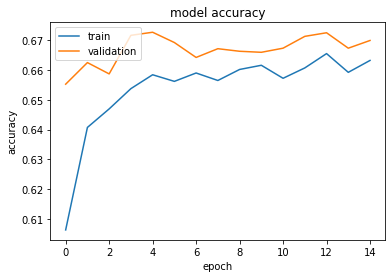

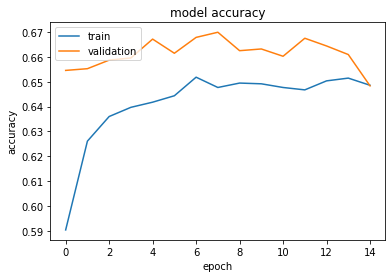

In [ ]:
plot_history(hist_1)
plot_history(hist_2)

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

Learning_rate = 0.0001

# #model compiling
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
Epoch = 20
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=15,shuffle=True,verbose=1,callbacks = [early_stop, rlrop])


Epoch 1/15
274/274 [==============================] - 30s 90ms/step - loss: 0.7621 - accuracy: 0.5626 - val_loss: 0.6271 - val_accuracy: 0.6552
Epoch 2/15
274/274 [==============================] - 24s 87ms/step - loss: 0.6810 - accuracy: 0.6269 - val_loss: 0.6117 - val_accuracy: 0.6632
Epoch 3/15
274/274 [==============================] - 23s 86ms/step - loss: 0.6649 - accuracy: 0.6375 - val_loss: 0.6087 - val_accuracy: 0.6648
Epoch 4/15
274/274 [==============================] - 27s 98ms/step - loss: 0.6506 - accuracy: 0.6496 - val_loss: 0.6012 - val_accuracy: 0.6685
Epoch 5/15
274/274 [==============================] - 24s 86ms/step - loss: 0.6402 - accuracy: 0.6567 - val_loss: 0.5955 - val_accuracy: 0.6741
Epoch 6/15
274/274 [==============================] - 23s 86ms/step - loss: 0.6350 - accuracy: 0.6499 - val_loss: 0.5921 - val_accuracy: 0.6771
Epoch 7/15
274/274 [==============================] - 23s 85ms/step - loss: 0.6310 - accuracy: 0.6568 - val_loss: 0.5889 - val_accuracy:

In [ ]:
model.evaluate(X_test,Y_test)

118/118 [==============================] - 7s 60ms/step - loss: 0.5779 - accuracy: 0.6936


[0.5779288411140442, 0.6935569643974304]

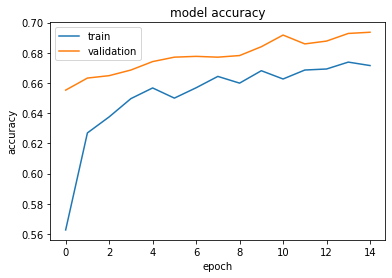

In [ ]:
def plot_history(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_history(history)

In [ ]:
#other model
batch_size = 50

hist = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size,
                 seed = 27, shuffle = False), 
                    epochs=25, # one forward/backward pass of training data
                    steps_per_epoch=X_train.shape[0]//batch_size, # number of images comprising of one epoch
                    validation_data=(X_test, Y_test), # data for validation,
                    verbose =1
                    )

Epoch 1/25
175/175 [==============================] - 61s 147ms/step - loss: 0.7780 - accuracy: 0.5527 - val_loss: 0.6417 - val_accuracy: 0.6470
Epoch 2/25
175/175 [==============================] - 24s 135ms/step - loss: 0.6882 - accuracy: 0.6193 - val_loss: 0.6290 - val_accuracy: 0.6547
Epoch 3/25
175/175 [==============================] - 24s 136ms/step - loss: 0.6737 - accuracy: 0.6391 - val_loss: 0.6233 - val_accuracy: 0.6605
Epoch 4/25
175/175 [==============================] - 24s 138ms/step - loss: 0.6600 - accuracy: 0.6424 - val_loss: 0.6213 - val_accuracy: 0.6595
Epoch 5/25
175/175 [==============================] - 24s 136ms/step - loss: 0.6522 - accuracy: 0.6418 - val_loss: 0.6185 - val_accuracy: 0.6621
Epoch 6/25
175/175 [==============================] - 24s 137ms/step - loss: 0.6368 - accuracy: 0.6532 - val_loss: 0.6162 - val_accuracy: 0.6613
Epoch 7/25
175/175 [==============================] - 24s 136ms/step - loss: 0.6304 - accuracy: 0.6566 - val_loss: 0.6116 - val_ac

In [ ]:
def model_B0(base_model):
  x = layers.Flatten()(base_model.output)
  x = layers.BatchNormalization()(x)
  # x = layers.Dense(1024, activation='elu')(x)
  x = layers.Dense(512, activation='elu')(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(256, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  # x = layers.Dense(5, activation='softmax')(x)
  x = layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.models.Model(base_model.input, x)
  return model

batch_size = 59
epochs = 50

learn_rate=.001

for layer in base_model.layers:
    layer.trainable = False

# opt = keras.optimizers.Adam(learning_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)


sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)

model = model_B0(base_model)
model.compile(optimizer = opt,loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size,
                 seed = 27, shuffle = False), 
                    epochs=25, # one forward/backward pass of training data
                    steps_per_epoch=X_train.shape[0]//batch_size, # number of images comprising of one epoch
                    validation_data=(X_test, Y_test), # data for validation,
                    verbose =2
                    )

Epoch 1/25
148/148 - 60s - loss: 1.2484 - accuracy: 0.6147 - val_loss: 0.6760 - val_accuracy: 0.6592
Epoch 2/25
148/148 - 23s - loss: 1.0724 - accuracy: 0.6379 - val_loss: 0.7643 - val_accuracy: 0.6659
Epoch 3/25
148/148 - 23s - loss: 1.0194 - accuracy: 0.6409 - val_loss: 0.7198 - val_accuracy: 0.6616
Epoch 4/25
148/148 - 23s - loss: 0.9075 - accuracy: 0.6463 - val_loss: 0.7157 - val_accuracy: 0.6331
Epoch 5/25
148/148 - 23s - loss: 0.8280 - accuracy: 0.6607 - val_loss: 0.6583 - val_accuracy: 0.6672
Epoch 6/25
148/148 - 27s - loss: 0.7541 - accuracy: 0.6679 - val_loss: 0.6339 - val_accuracy: 0.6709
Epoch 7/25
148/148 - 23s - loss: 0.6942 - accuracy: 0.6725 - val_loss: 0.6100 - val_accuracy: 0.6771
Epoch 8/25
148/148 - 23s - loss: 0.6417 - accuracy: 0.6918 - val_loss: 0.6030 - val_accuracy: 0.6749
Epoch 9/25
148/148 - 23s - loss: 0.6261 - accuracy: 0.6970 - val_loss: 0.6011 - val_accuracy: 0.6691
Epoch 10/25
148/148 - 23s - loss: 0.5920 - accuracy: 0.7003 - val_loss: 0.5972 - val_accura